# Zadania
1. Utwórz dwie nowe kolumny w ramce "Countries", w których powierzchnia i gęstość zaludnienia wyrażone sa odpowiednio w milach kwadratowych i osobach na milę kwadratową. 
  - Przelicznik: 1 mila kwadratowa = 0.38610 km kwadratowego (powierzchnię należy pomnożyć, a gęstość zaludnienia podzielić przez ten współczynnik)
  - Typami nowych kolumn mają być odpowiednio integer (powierzchnia) i float (gęstość). Zaokrąglanie do integer: "int(x)"
  - Nazwy nowych kolumn proszę ustawić odpowiednio na '<tt>Area (sq mi)</tt>' oraz '<tt>Pop Density (per sq mi)</tt>'
1. Na wykresie scatterplot narysuj zależność liczby lotnisk od powierzchni kraju. 
  - Dane potrzebne do wykresu są w dwóch ramkach (Countries i Airports), konieczne więc będzie ich złączenie (join).
  - Wskazówka: w pierwszym etapie stwórz ramkę agregującą liczbę lotnisk w zależności od kraju. W drugim etapie złącz (join) tę ramkę z ramką countries. Kolumną wspólną (warunkiem złączenia) będzie Country.
  - Nie zawsze nazwy tych samych krajów będą identyczne w obu ramkach, co może stanowić problem (złączenie nie powstanie). Zastanów się jak przy pomocy mechanizmu złączeń wykryć, które nazwy się różnią. Stwórz odpowiednią ramkę, która zawiera takie nazwy. 
  - Następnie zmień nazwy kilku największych państw w jednej z ramek, tak żeby ujednolicić nazwy. Można to zrobić funkcją replace:
<br><tt>cdf=cdf.replace(['Korea, South', 'Korea, North'], ['South Korea', 'North Korea'], 'Country')</tt>
1. Do ramki "Countries" dodaj nową kolumnę "Continent" (według klasyfikacji Africa, Asia, Europe, North America, South America, Antarctica, Australia/Oceania). 
  - Skorzystaj z kolumny "Region" i pomocniczej funkcji (UDF) mapującej region na kontynent.
1. Oblicz, ile lotnisk jest na poszczególnych kontynentach. To zadanie również wymaga złączenia ramek "Countries" i "Airports". Wynik przedstaw na wykresie słupkowym.


In [1]:
from pyspark.sql import SparkSession

In [2]:
import pandas as pd

In [3]:
import numpy as np

In [4]:
spark = SparkSession.builder.getOrCreate()

In [5]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

In [6]:
# Wbudowane funkcje, które mogą być przydatne:
# - udf: służy do tworzenia funkcji użytkownika
# - trim: usuwa białe spacje z początku i końca stringu
# - isnull: testuje, czy wartość jest pusta
from pyspark.sql.functions import col, udf, trim, isnull
from pyspark.sql.types import FloatType, IntegerType

In [7]:
def to_float (s) :
   return float(s.replace(',','.'))
float_udf = udf(to_float , FloatType())

def to_int (s) :
   return int(s)
int_udf = udf(to_int , IntegerType())


In [8]:
countries = spark.read.csv("countries of the world.csv",inferSchema=True,header=True)

# Usuwa kropki z wszystkich nazw kolumn (powodują wiele błędów, prawdopodobnie bug w Sparku)
# (Nb. wszystkie inne metody zmiany tych nazw (np. użycie columnRenamed) zawiodły)
new_columns=[s.replace('.','') for s in countries.columns]
countries=countries.toDF(*new_columns) # tutaj '*' to operator "splat" -- robi z tablicy listę argumentów

# Tak można ustawić wyświetlanie większej liczby wierszy w Jupyterze
pd.set_option('display.max_rows', 20)
#display(countries.limit(5).toPandas())

In [9]:
# Utworzenie nowej ramki 'cdf':
# - wartosci puste wypelnione "-1", zeby nie usuwac wierszy
# - trim stringów (w nazwach występują niepożądane spacje na końcu)
# - konwersja wszystkich kolumn zmiennoprzecinkowych na float
# - zmiana 'sq mi' na 'sq km', bo w zbiorze wartości są faktycznie w km^2, a nie milach^2
cdf=countries.na.fill("-1").select( 
                 trim(col('Country')).alias('Country'),\
                 trim(col('Region')).alias('Region'),'Population',\
                 col('`Area (sq mi)`').alias('Area (sq mi)'),\
                 float_udf('`Pop Density (per sq mi)`').alias('Pop Density (per sq mi)'),\
                 float_udf('Coastline (coast/area ratio)').alias('Coastline (coast/area ratio)'),\
                 float_udf('Net migration').alias('Net migration'),\
                 float_udf('Infant mortality (per 1000 births)').alias('Infant mortality (per 1000 births)'),\
                 'GDP ($ per capita)',\
                 float_udf('Literacy (%)').alias('Literacy (%)'),\
                 float_udf('Phones (per 1000)').alias('Phones (per 1000)'),\
                 float_udf('Arable (%)').alias('Arable (%)'),\
                 float_udf('Crops (%)').alias('Crops (%)'),\
                 float_udf('Other (%)').alias('Other (%)'),\
                 float_udf('Birthrate').alias('Birthrate'),\
                 float_udf('Deathrate').alias('Deathrate'),\
                 float_udf('Agriculture').alias('Agriculture'),\
                 float_udf('Industry').alias('Industry'),\
                 float_udf('Service').alias('Service'))
cdf.limit(2).toPandas()

,Country,Region,Population,Area (sq mi),Pop Density (per sq mi),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,48.000000,0.00,23.059999,163.070007,700,36.0,3.200000,12.13,0.22,87.650002,46.599998,20.34,0.380,0.240,0.380
1,Albania,EASTERN EUROPE,3581655,28748,124.599998,1.26,-4.930000,21.520000,4500,86.5,71.199997,21.09,4.42,74.489998,15.110000,5.22,0.232,0.188,0.579


# Zadanie 1: nowe kolumny

In [10]:
cdf = cdf.withColumn('Area (sq km)',int_udf(col('Area (sq mi)')*0.38610*0.38610))
cdf = cdf.withColumn('Pop Density (per sq km)',int_udf(col('Pop Density (per sq mi)')*0.38610*0.38610))
cdf.limit(2).toPandas()

,Country,Region,Population,Area (sq mi),Pop Density (per sq mi),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),...,Arable (%),Crops (%),Other (%),Birthrate,Deathrate,Agriculture,Industry,Service,Area (sq km),Pop Density (per sq km)
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,48.000000,0.00,23.059999,163.070007,700,36.0,...,12.13,0.22,87.650002,46.599998,20.34,0.380,0.240,0.380,96524,7
1,Albania,EASTERN EUROPE,3581655,28748,124.599998,1.26,-4.930000,21.520000,4500,86.5,...,21.09,4.42,74.489998,15.110000,5.22,0.232,0.188,0.579,4285,18


# Join examples

In [11]:
valuesA = [('Pirate',1),('Monkey',2),('Ninja',3),('Spaghetti',4)]
TableA = spark.createDataFrame(valuesA,['name','id'])
 
valuesB = [('Rutabaga',1),('Pirate',2),('Ninja',3),('Darth Vader',4)]
TableB = spark.createDataFrame(valuesB,['name','id'])

In [12]:
a=TableA.alias('a')
b=TableB.alias('b')

In [13]:
a.join(b, a.name==b.name, how='left').show()

+---------+---+------+----+
|     name| id|  name|  id|
+---------+---+------+----+
|Spaghetti|  4|  null|null|
|    Ninja|  3| Ninja|   3|
|   Pirate|  1|Pirate|   2|
|   Monkey|  2|  null|null|
+---------+---+------+----+



In [14]:
a.join(b, a.name==b.name, how='right').show()

+------+----+-----------+---+
|  name|  id|       name| id|
+------+----+-----------+---+
|  null|null|   Rutabaga|  1|
| Ninja|   3|      Ninja|  3|
|Pirate|   1|     Pirate|  2|
|  null|null|Darth Vader|  4|
+------+----+-----------+---+



In [15]:
a.join(b, a.name==b.name, how='full_outer').show()

+---------+----+-----------+----+
|     name|  id|       name|  id|
+---------+----+-----------+----+
|     null|null|   Rutabaga|   1|
|Spaghetti|   4|       null|null|
|    Ninja|   3|      Ninja|   3|
|   Pirate|   1|     Pirate|   2|
|   Monkey|   2|       null|null|
|     null|null|Darth Vader|   4|
+---------+----+-----------+----+



# Zadanie 2: zależność liczby lotnisk od powierzchni kraju 

In [16]:
# Read in the airports data
arp = spark.read.csv("airportsAll.csv",inferSchema=True,header=False).\
toDF("id","airport","city","country","iata","icao","latitude","longitude","altitude","timezone","dst","tz_timezone","type","data_source")
# zacznij od stworzenia ramki, która zawiera posortowaną liczbę lotnisk w poszczególnych krajach
arpByCountry = arp.groupBy(col('country')).count().orderBy('country')

#arpByCountry.limit(2).toPandas()

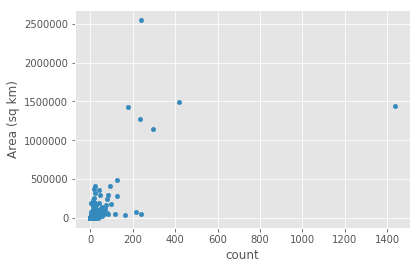

In [29]:
# TODO złączenie ramek i wykres
cdf=cdf.replace(['Antigua & Barbuda','British Virgin Is.','Saint Kitts & Nevis','Gambia, The'], 
                ['Antigua and Barbuda','British Virgin Islands','Saint Kitts and Nevis','Gambia'],
                'Country')
a = cdf.alias('a')
c= arpByCountry.alias('c')
a.join(c, a.Country==c.country).toPandas().plot(x="count",y="Area (sq km)",kind="scatter")

In [30]:
# TODO wykrycie niepasujących nazw państwa i ujednolicenie wartości 
ac = a.join(c, a.Country==c.country, how='full_outer').\
filter((col('a.Country').isNull()) | (col('c.country').isNull()) )

a1 = ac.\
filter(col('a.Country').isNull() != 1).\
select(col('a.Country'))
#a1.toPandas()

c1 = ac.\
filter(col('c.country').isNull() != 1).\
select(col('c.country'))
#c1.toPandas()

a1.join(c1, a1.Country.substr(1, 3)==c1.country.substr(1, 3)).toPandas()


----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 53314)
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.6/site-packages/py4j/java_gateway.py", line 1188, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.6/site-packages/py4j/java_gateway.py", line 1014, in send_command
    response = connection.send_command(command)
  File "/home/ubuntu/.local/lib/python3.6/site-packages/py4j/java_gateway.py", line 1193, in send_command
    "Error while receiving", e, proto.ERROR_ON_RECEIVE)
py4j.protocol.Py4JNetworkError: Error while receiving
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:33277)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/home/ubuntu/spark-2.4.0-bin-hadoop2.7/python/pyspark/accumulators.py", line 268, in handle
    poll(accum_updates)
  File "/home/ubuntu/spark-2.4.0-bin-hadoop2.7/python/pyspark/accumulators.py", line 241, in poll
    if func():
  File "/home/ubuntu/spark-2.4.0-bin-hadoop2.7/python/pyspark/accumulators.py", line 245, in accum_updates
    num_updates = read_int(self.rfile)
  File

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:33277)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/home/ubuntu/spark-2.4.0-bin-hadoop2.7/python/pyspark/accumulators.py", line 268, in handle
    poll(accum_updates)
  File "/home/ubuntu/spark-2.4.0-bin-hadoop2.7/python/pyspark/accumulators.py", line 241, in poll
    if func():
  File "/home/ubuntu/spark-2.4.0-bin-hadoop2.7/python/pyspark/accumulators.py", line 245, in accum_updates
    num_updates = read_int(self.rfile)
  File

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:33277)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/home/ubuntu/spark-2.4.0-bin-hadoop2.7/python/pyspark/accumulators.py", line 268, in handle
    poll(accum_updates)
  File "/home/ubuntu/spark-2.4.0-bin-hadoop2.7/python/pyspark/accumulators.py", line 241, in poll
    if func():
  File "/home/ubuntu/spark-2.4.0-bin-hadoop2.7/python/pyspark/accumulators.py", line 245, in accum_updates
    num_updates = read_int(self.rfile)
  File

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:33277)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/home/ubuntu/spark-2.4.0-bin-hadoop2.7/python/pyspark/accumulators.py", line 268, in handle
    poll(accum_updates)
  File "/home/ubuntu/spark-2.4.0-bin-hadoop2.7/python/pyspark/accumulators.py", line 241, in poll
    if func():
  File "/home/ubuntu/spark-2.4.0-bin-hadoop2.7/python/pyspark/accumulators.py", line 245, in accum_updates
    num_updates = read_int(self.rfile)
  File

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:33277)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/home/ubuntu/spark-2.4.0-bin-hadoop2.7/python/pyspark/accumulators.py", line 268, in handle
    poll(accum_updates)
  File "/home/ubuntu/spark-2.4.0-bin-hadoop2.7/python/pyspark/accumulators.py", line 241, in poll
    if func():
  File "/home/ubuntu/spark-2.4.0-bin-hadoop2.7/python/pyspark/accumulators.py", line 245, in accum_updates
    num_updates = read_int(self.rfile)
  File

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:33277)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/home/ubuntu/spark-2.4.0-bin-hadoop2.7/python/pyspark/accumulators.py", line 268, in handle
    poll(accum_updates)
  File "/home/ubuntu/spark-2.4.0-bin-hadoop2.7/python/pyspark/accumulators.py", line 241, in poll
    if func():
  File "/home/ubuntu/spark-2.4.0-bin-hadoop2.7/python/pyspark/accumulators.py", line 245, in accum_updates
    num_updates = read_int(self.rfile)
  File

  File "/home/ubuntu/spark-2.4.0-bin-hadoop2.7/python/pyspark/accumulators.py", line 245, in accum_updates
    num_updates = read_int(self.rfile)
  File "/home/ubuntu/spark-2.4.0-bin-hadoop2.7/python/pyspark/serializers.py", line 714, in read_int
    raise EOFError
EOFError
----------------------------------------


Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:33277)

# Zadanie 3

In [19]:
# TODO

# Zadanie 4

In [20]:
# TODO